# Title :

---

## Introduction

lorem ipsum

## Methodology

lorem ipsum

### Preprocessing

In [ ]:
# Import Library
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [17]:
# Open dataset
df = xr.open_dataset("cru_ts4.09.1901.2024.tmp.dat.nc") # lazy loading, tmp files
uk = gpd.read_file("geoBoundaries-GBR-ADM1-all/geoBoundaries-GBR-ADM1.shp").to_crs(epsg=4326) # uk boundaries shp
scot = uk[uk["shapeName"] == "Scotland"].dissolve() # dissolve to single polygon

minx, miny, maxx, maxy = scot.total_bounds
print("Lon:", minx, maxx, "Lat:", miny, maxy)
geom = scot.geometry.iloc[0]

pad = 0.15 # add some padding around the polygon to make sure we get all of it (and a bit of sea around)
minx1, maxx1 = minx - pad, maxx + pad
miny1, maxy1 = miny - pad, maxy + pad

df_scot = df.sel(lon=slice(minx1, maxx1), lat=slice(miny1, maxy1))
print(df_scot)

Lon: -8.645449000271071 -0.738072999669157 Lat: 54.63919599969569 60.843381000432885
<xarray.Dataset> Size: 7MB
Dimensions:  (lon: 17, lat: 13, time: 1488)
Coordinates:
  * lon      (lon) float32 68B -8.75 -8.25 -7.75 -7.25 ... -1.75 -1.25 -0.75
  * lat      (lat) float32 52B 54.75 55.25 55.75 56.25 ... 59.75 60.25 60.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    tmp      (time, lat, lon) float32 1MB ...
    stn      (time, lat, lon) float64 3MB ...
    mae      (time, lat, lon) float32 1MB ...
    maea     (time, lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    

#### Datasets Description

1. <div align="justify"> `tmp` : The temperature variable `tmp` represents the monthly mean surface air temperature recorded at each grid cell across UK domain. Observations are provided on a regular latitude-longitude grid and span the period from January 1901 to December 2024. </div>
2. <div align="justify"> `lat`/`lon` : Latitude/Longitude </div>
3. <div align="justify"> `time` : The time dimension represents monthly observations spanning January 1901 to December 2024. Each timestamp corresponds to a monthly average temperature value.</div>
4. <div align="justify"> `stn` : The station count variable represents the number of observational weather stations contributing to the interpolation process used to estimate temperature at each grid cell. Higher station counts indicate stronger observational support and potentially lower uncertainty, whereas lower values suggest greater reliance on spatial interpolation and therefore increased uncertainty. For example, `stn` = 12 i.e. temperature estimate derived using data from 12 nearby stations.</div>



---

#### Exploring Temperature Across Scotland Region from 1901 to 2024

In [19]:
tmp = df_scot["tmp"]  # (time, lat, lon)

# Scotland-wide area-weighted mean
scot_mean = tmp.mean(("lat", "lon")).rename("scotland_tmp_mean")
print(scot_mean)

<xarray.DataArray 'scotland_tmp_mean' (time: 1488)> Size: 6kB
array([3.2009177, 1.8055046, 2.9880736, ..., 9.741285 , 6.5440373,
       5.8467894], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16


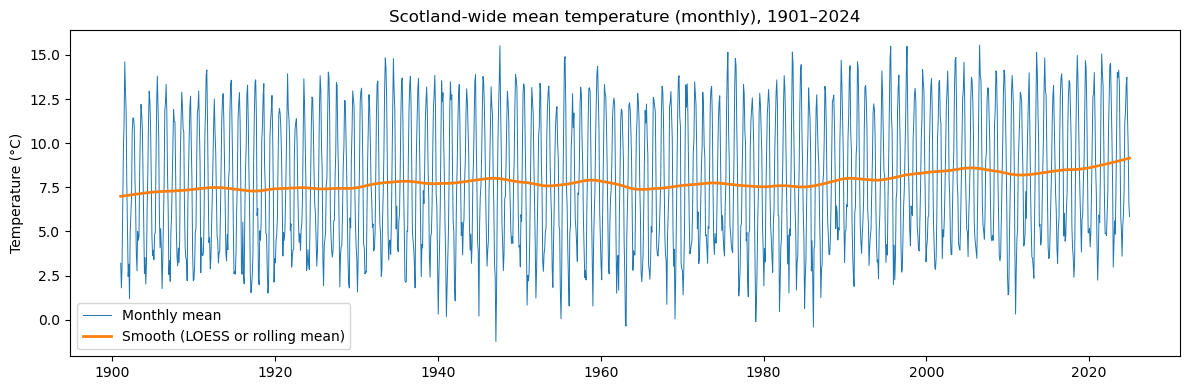

In [21]:
# Scotland-wide mean temperature time series + LOESS smoothing to show long-term trend
def smooth_loess(time_da, y, frac=0.08):
    """
    time_da: xarray time coordinate
    y: 1D numpy array
    frac: LOESS span (0-1). Larger = smoother
    """
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        x = np.arange(len(y))
        yhat = lowess(y, x, frac=frac, return_sorted=False)
        return yhat
    except Exception:
        # fallback: ~10-year rolling mean (monthly)
        return xr.DataArray(y, coords={"time": time_da}, dims=("time",)).rolling(time=120, center=True).mean().values

y = scot_mean.values
y_smooth = smooth_loess(scot_mean["time"], y, frac=0.08)

plt.figure(figsize=(12, 4))
plt.plot(scot_mean["time"].values, y, linewidth=0.7, label="Monthly mean")
plt.plot(scot_mean["time"].values, y_smooth, linewidth=2.0, label="Smooth (LOESS or rolling mean)")
plt.title("Scotland-wide mean temperature (monthly), 1901–2024")
plt.ylabel("Temperature (°C)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> The Scotland-wide monthly mean temperature series exhibits a pronounced seasonal oscillation superimposed on a gradually increasing long-term mean. While the raw monthly values fluctuate strongly between winter and summer, the smoothed trend reveals a clear upward trajectory from the early 20th century to the present, with particularly accelerated warming after the 1980s. This pattern suggests that the dominant climate signal operates at a low temporal frequency rather than as a simple linear increase. Such nonlinearity motivates the use of a flexible temporal structure in the proposed Bayesian model, such as a random walk or spline-based latent trend component, rather than a strictly linear time effect. </div>

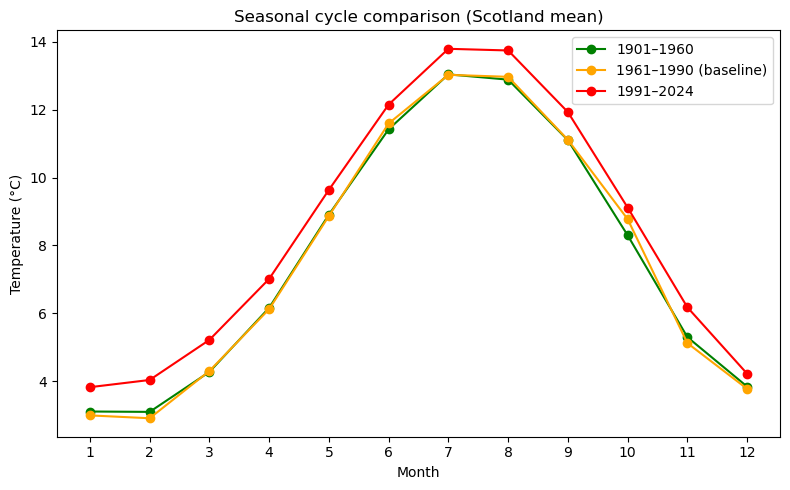

In [22]:
# seasonal cycle (climatology) comparison using WMO baseline (1961-1990)
# How far is each month relative to the reference climate? (baseline)
baseline = scot_mean.sel(time=slice("1961-01-01", "1990-12-31")) \
                    .groupby("time.month").mean("time")
early = scot_mean.sel(time=slice("1901-01-01", "1960-12-31")) \
                 .groupby("time.month").mean("time")

late = scot_mean.sel(time=slice("1991-01-01", "2024-12-31")) \
                .groupby("time.month").mean("time")

plt.figure(figsize=(8,5))
plt.plot(early["month"], early, marker="o", label="1901–1960", color= "green")
plt.plot(baseline["month"], baseline, marker="o", label="1961–1990 (baseline)", color = "orange")
plt.plot(late["month"], late, marker="o", label="1991–2024", color = "red")

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title("Seasonal cycle comparison (Scotland mean)")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> The seasonal cycle remains structurally stable across all three periods, with minimum in winter and maximum in summer occurring consistently in January-February and July-August, respectively. However, the more recent period (1991-2024) exhibits a systematic upward shift relative to both the early 20th century and the baseline period. The near-parallel displacement of the curves suggests that warming primarily acts as an additive shift to the annual cycle rather than altering its amplitude or timing. This justifies modelling temperature as the sum of a seasonal component and a temporally evolving mean, where seasonality can be represented using monthly fixed effects or harmonic terms within the hierarchical framework. </div>

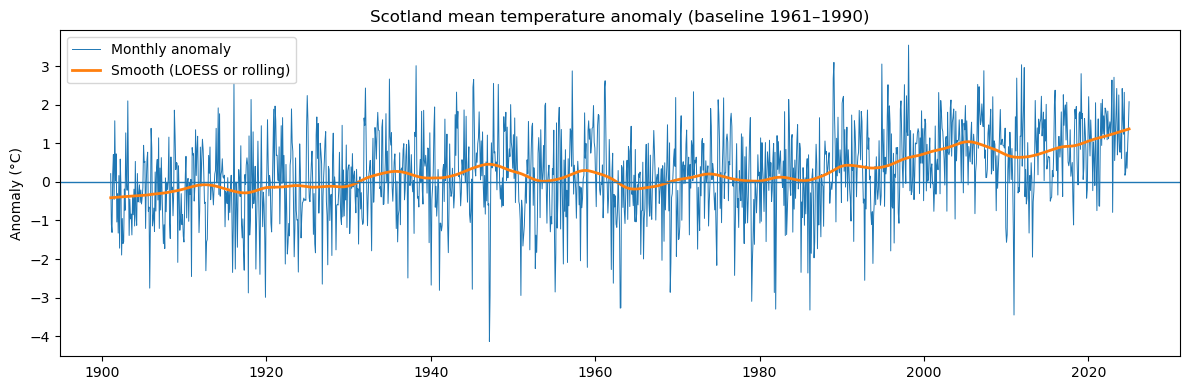

In [23]:
# Monthly anomalies relative to baseline climatology
anom = scot_mean.groupby("time.month") - baseline
anom = anom.rename("scotland_tmp_anom")

y_anom = anom.values
y_anom_smooth = smooth_loess(anom["time"], y_anom, frac=0.08)

plt.figure(figsize=(12, 4))
plt.plot(anom["time"].values, y_anom, linewidth=0.7, label="Monthly anomaly")
plt.plot(anom["time"].values, y_anom_smooth, linewidth=2.0, label="Smooth (LOESS or rolling)")
plt.axhline(0, linewidth=1)
plt.title("Scotland mean temperature anomaly (baseline 1961–1990)")
plt.ylabel("Anomaly (°C)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> After removing the seasonal cycle, the anomaly series highlights persistent deviations from the historical climate normal. Early decades are characterised by predominantly negative or near-zero anomalies, whereas post-1990 observations are largely positive, indicating sustained warming relative to the baseline. The smoothed anomaly curve confirms a nonlinear increase, particularly pronounced in recent decades. By eliminating deterministic seasonality, the anomaly formulation isolates the long-term climatic signal, making it more suitable for hierarchical spatio-temporal modelling. This supports modelling the latent temporal trend directly on the anomaly scale, improving interpretability and reducing confounding between trend and seasonal effects. </div>

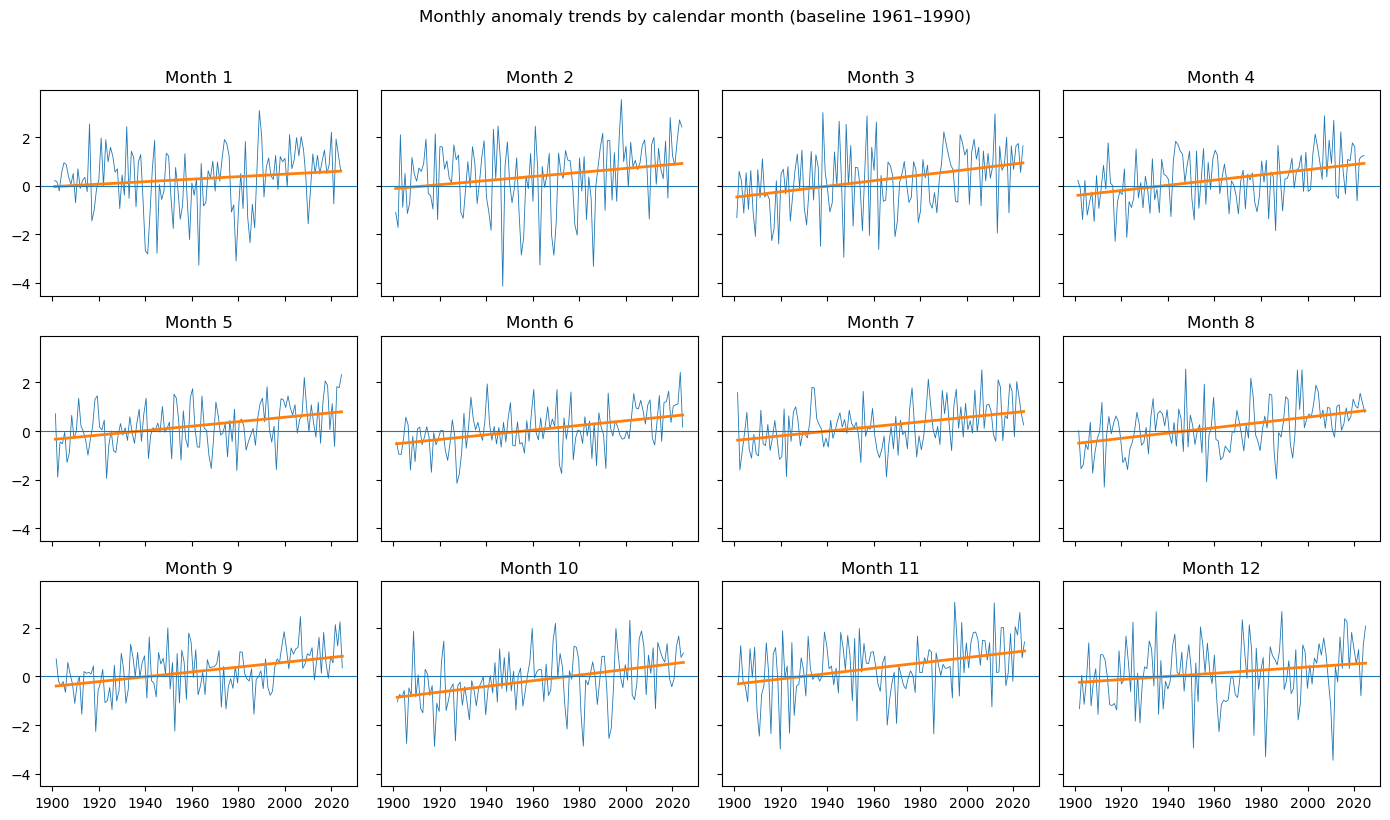

In [24]:
# trend by month (anomalies over time per month)
t = anom["time"]
year = (t.dt.year + (t.dt.dayofyear - 1) / 365.25).values  # approx

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for m in range(1, 13):
    ax = axes[m - 1]
    a_m = anom.where(anom["time.month"] == m, drop=True)

    # points/line
    ax.plot(a_m["time"].values, a_m.values, linewidth=0.6)

    # linear trend (quick diagnostic)
    yr_m = (a_m["time"].dt.year + (a_m["time"].dt.dayofyear - 1) / 365.25).values
    y_m = a_m.values
    ok = np.isfinite(yr_m) & np.isfinite(y_m)
    if ok.sum() > 2:
        b1, b0 = np.polyfit(yr_m[ok], y_m[ok], 1)  # y = b1*year + b0
        yfit = b1 * yr_m + b0
        ax.plot(a_m["time"].values, yfit, linewidth=2.0)

    ax.set_title(f"Month {m}")

fig.suptitle("Monthly anomaly trends by calendar month (baseline 1961–1990)", y=1.02)
for ax in axes:
    ax.axhline(0, linewidth=0.8)
plt.tight_layout()
plt.show()

<div align="justify"> The month-specific anomaly trends reveal positive slopes across all twelve calendar months, indicating that warming is a year-round phenomenon rather than seasonally confined. While the magnitude of increase varies modestly across months, no month exhibits a cooling tendency. This suggests that seasonal effects and long-term warming interact, but that the warming signal is broadly coherent across seasons. These findings motivate either a common temporal trend shared across months or, alternatively, a model allowing for month-specific slope deviations within a hierarchical structure. </div>

In [25]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# function to clip raster to polygon
def clip_raster_to_geom(ax, geom, collection_index=0):
    """Clip the first QuadMesh/collection produced by xarray.plot() to a (Multi)Polygon."""
    geoms = geom.geoms if geom.geom_type == "MultiPolygon" else [geom]
    vertices, codes = [], []

    for poly in geoms:
        x, y = poly.exterior.coords.xy
        verts = np.column_stack([x, y])
        c = np.full(len(verts), Path.LINETO, dtype=np.uint8)
        c[0] = Path.MOVETO
        vertices.append(verts)
        codes.append(c)

    vertices = np.vstack(vertices)
    codes = np.concatenate(codes)

    patch = PathPatch(Path(vertices, codes), transform=ax.transData)
    ax.collections[collection_index].set_clip_path(patch)

**Dataset to Use in R**

In [31]:
# baseline climatology per cell, per month (1961–1990)
tmp_base = tmp.sel(time=slice("1961-01-01", "1990-12-31"))
clim_6190 = tmp_base.groupby("time.month").mean("time")  # dims: (month, lat, lon)

# anomaly per cell, per time
anom_cell = (tmp.groupby("time.month") - clim_6190).rename("anom")

# create one dataset containing both raw data and anomaly
ds_scotland = xr.Dataset(
    data_vars={
        "tmp": tmp,         # raw Scotland temps (time, lat, lon)
        "anom": anom_cell        # anomalies (time, lat, lon)
    },
    coords={
        "time": tmp["time"],
        "lat": tmp["lat"],
        "lon": tmp["lon"]
    }
)

print(ds_scotland)

anom_mean = scot_mean.groupby("time.month") - baseline

ds_scotland["scot_mean_tmp"] = scot_mean
ds_scotland["scot_mean_anom"] = anom_mean.rename("scot_mean_anom")

ds_scotland
ds_scotland.to_netcdf("ds_scotland.nc")

<xarray.Dataset> Size: 3MB
Dimensions:  (lon: 17, lat: 13, time: 1488)
Coordinates:
  * lon      (lon) float32 68B -8.75 -8.25 -7.75 -7.25 ... -1.75 -1.25 -0.75
  * lat      (lat) float32 52B 54.75 55.25 55.75 56.25 ... 59.75 60.25 60.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
    month    (time) int64 12kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tmp      (time, lat, lon) float32 1MB 3.6 3.8 3.4 3.5 ... nan 5.8 5.6 6.6
    anom     (time, lat, lon) float32 1MB 0.04333 0.05 -0.06667 ... 1.777 2.787


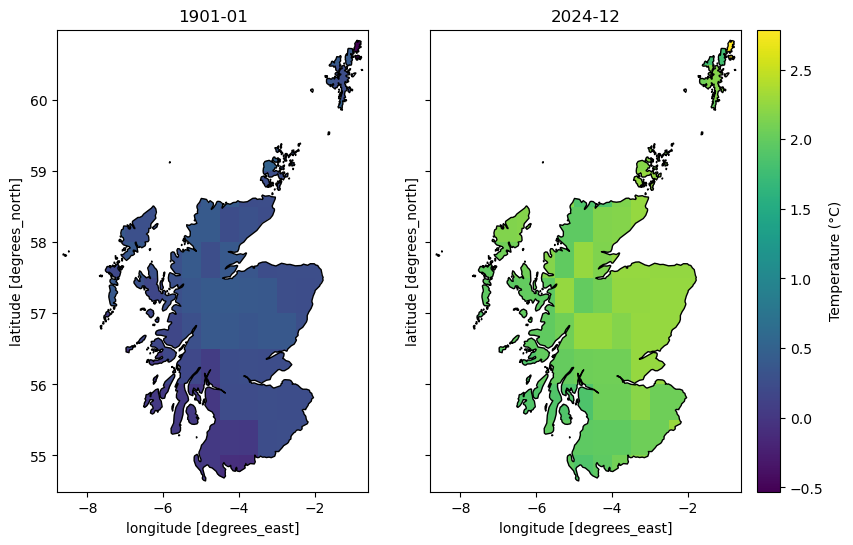

In [32]:
# Scotland comparison plot (1901-01 vs 1014-12) with clipped coastline
# pick two times
ds_0 = ds_scotland["anom"].isel(time=0) # 1901-01
ds_n = ds_scotland["anom"].isel(time=1487) # 2024-12

# compute shared color scale
vmin = float(min(ds_0.min(), ds_n.min()))
vmax = float(max(ds_0.max(), ds_n.max()))

# create side-by-side plots
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 6),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.05}
)

# first plot
im0 = ds_0.plot(
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[0].set_title("1901-01")

# second plot
im1 = ds_n.plot(
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[1].set_title("2024-12")

# clip both to Scotland
clip_raster_to_geom(axes[0], geom)
clip_raster_to_geom(axes[1], geom)

# draw boundary
scot.boundary.plot(ax=axes[0], color="black", linewidth=1)
scot.boundary.plot(ax=axes[1], color="black", linewidth=1)

# same extent
for ax in axes:
    ax.set_xlim(minx1, maxx1)
    ax.set_ylim(miny1, maxy1)

# shared colorbar
fig.colorbar(
    axes[1].collections[0],
    ax=axes,
    label="Temperature (°C)",
    fraction=0.04,
    pad=0.02
)

plt.show()

<div align="justify"> The spatial maps present temperature anomalies relative to the 1961–1990 climatological baseline, rather than absolute temperature levels. As such, the figures do not depict inherent geographical climate differences (e.g., coastal versus inland contrasts), but instead illustrate deviations from each location’s historical norm. In January 1901, anomalies are predominantly near or below zero across Scotland, indicating that temperatures during this period were generally cooler relative to the late 20th-century reference period. By contrast, the map for December 2024 shows uniformly positive anomalies across nearly all grid cells, reflecting widespread warming relative to the baseline. </div> <br>

<div align="justify"> A clear upward shift in the entire anomaly field is evident when comparing the early and late periods. This shift is spatially pervasive, suggesting that warming has occurred across Scotland rather than being confined to specific regions. Importantly, although the overall level of anomalies increases substantially over time, the spatial configuration of relative deviations remains broadly recognisable. Areas that exhibit relatively higher or lower anomalies in the earlier period tend to retain similar relative positioning in the later period, albeit shifted upward. This indicates that while warming is widespread, it is not perfectly spatially homogeneous; persistent local deviations from the national mean remain present.</div> <br>

<div align="justify"> Because anomalies remove the deterministic seasonal cycle and long-term climatological mean, they isolate the interannual and multi-decadal warming signal. Consequently, the spatial structure observed in the anomaly maps reflects stable geographical heterogeneity in relative temperature deviations rather than fixed climate gradients. The near-universal transition from negative or near-zero anomalies in the early twentieth century to consistently positive anomalies in recent decades provides strong empirical evidence of sustained, nationwide warming.</div> <br>

<div align="justify"> Taken together, the spatial and temporal patterns suggest that Scotland’s temperature anomaly field can be decomposed into a smooth long-term temporal trend, persistent spatial structure, and potentially space–time interaction effects capturing regional differences in warming intensity. These exploratory findings directly motivate a Bayesian hierarchical spatio-temporal modelling framework in which anomalies are expressed as the sum of nonlinear temporal components, spatial random effects, and optional interaction terms to account for evolving regional variation in warming rates.</div> <br>

---

#### Fitting the Model with a Bayesian Hierarchical Spatio-Temporal Model

Suppose temperature at spatial location $s$ and month $t$ is modelled as:

$$
y_{s,t} = \mu + f_{\text{trend}}(t) + f_{\text{space}}(s) + f_{\text{interaction}}(s,t) + \epsilon_{s,t},
$$

where $m_t \in \{1,\dots,12\}$ denotes the month-of-year corresponding to time $t$.

Model components

- $\mu$: Global mean temperature level.

- $f_{\text{trend}}(t)$: Long-term temporal trend.  
  This represents systematic change over time (e.g., long-term warming). Depending on the specification, it may be modelled as a smooth function of time (e.g., random walk, spline, or GP) and/or include temporal dependence (e.g., AR(1)).

- $f_{\text{space}}(s)$: Spatial effect.  
  This captures persistent geographic variation across longitude and latitude. It is commonly modelled using a Gaussian Process (GP), often with a Matérn covariance function, to enforce spatial smoothness.

- $f_{\text{interaction}}(s,t)$: Spatio-temporal interaction effect.  
  This term allows the spatial pattern to evolve over time during the study period.

- $\epsilon_{s,t}$: Observation noise.  
  This represents residual variation not explained by the trend, spatial, or interaction components, and is typically assumed to be independent Gaussian noise with variance $\sigma^2$.

Hierarchical structure

This model is hierarchical because $f_{\text{trend}}(t)$, $f_{\text{space}}(s)$, and $f_{\text{interaction}}(s,t)$ are treated as latent components with prior distributions. Their hyperparameters (e.g., trend smoothness or temporal correlation strength, spatial length-scale, and interaction variance) are inferred from the data.

Overall, the model comprises multiple levels: (i) observed temperature anomaly measurements, (ii) temporal trend, latent spatial, and spatio-temporal interaction components, and (iii) hyperparameters governing these components. This hierarchical structure enables joint inference on long-term warming trends, persistent spatial contrasts, and potential evolution of spatial patterns over time.


##### 1️. Checking whether temperature depends on time (temporal effect)

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=np.True_, p=np.float64(5.668221447763244e-11), z=np.float64(6.552234859225504), Tau=np.float64(0.21916827559277177), s=np.float64(242472.0), var_s=np.float64(1369432704.1837068), slope=np.float64(0.0008202889074282876), intercept=np.float64(-0.39730067220694754))

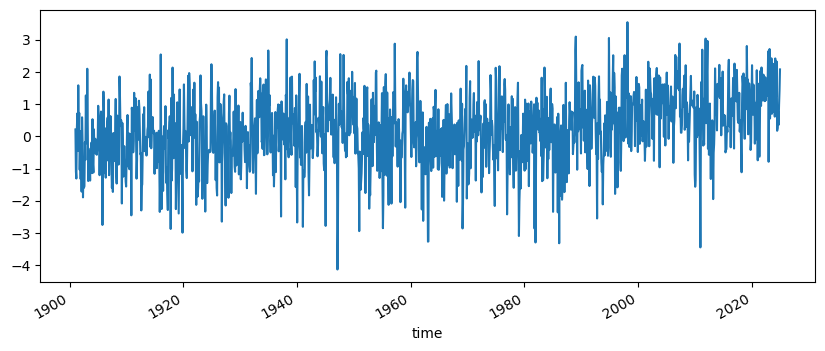

In [45]:
ts_mean = ds_scotland["anom"].mean(dim=("lat","lon"))
ts = ts_mean.to_pandas()
ts.plot(figsize=(10,4))

import pymannkendall as mk
mk.hamed_rao_modification_test(ts)

<div align="justify">  A modified Mann–Kendall test accounting for serial correlation (Hamed–Rao approach) confirms a statistically significant increasing trend in Scotland-wide monthly temperature anomalies (z = 6.55, p < 0.001). The Sen’s slope estimate of 0.00082°C per month corresponds to approximately 0.0098°C per year, implying an overall warming of about 0.98°C over a 100-year period. </div>

##### 2️. Checking whether temperature depends on region (spatial effect)

In [52]:
import libpysal
from esda.moran import Moran
import matplotlib.pyplot as plt

# Generate mean temperature over time
mean_map = ds_scotland["anom"].mean(dim="time")

# latten temperature values and matching lon/lat grid
mean_temp = mean_map.values.flatten()
lon2d, lat2d = np.meshgrid(ds_scotland["lon"].values, ds_scotland["lat"].values)
coords = np.column_stack([lon2d.flatten(), lat2d.flatten()])

# Remove NaN 
mask = np.isfinite(mean_temp)          # keeps only non-NaN 
mean_temp_clean = mean_temp[mask]
coords_clean = coords[mask]

# Construct spatial weights
w = libpysal.weights.KNN.from_array(coords_clean, k=8)
w.transform = "r"

# Calculate Moran's I
mi = Moran(mean_temp_clean, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)
print("Number of locations used:", len(mean_temp_clean))

Moran's I: 0.5319168842179607
p-value: 0.001
Number of locations used: 109


<div align="justify"> Moran’s I was computed to assess spatial autocorrelation in the mean temperature map across Scotland. The statistic was 0.532 (p = 0.001), indicating strong and statistically significant positive spatial autocorrelation. This suggests that nearby grid cells exhibit similar temperature levels, confirming the presence of spatial clustering. These findings justify the inclusion of a spatial random effect in the hierarchical spatio-temporal model. </div>

##### 3. Checking whether temperature depends on a spatio-temporal interation

In [ ]:
# insert code here